In [1]:
import numpy as np

# Formatting the Binomial Tree

Each node in the binomial tree can be represented using coordinates $(i,j)$, where $j$ repressents the height of the tree and $i$ represents the time-step, N represents terminal time, $u$ represents an up-tick, $d$ represents a down-tick in the underlying's value and $l$ represents the continuous dividend yield of the underlying.

**Steps**

We first find the price of the underlying at each node: $S_{i,j} = S_{0}u^{j}d^{i-j}$.

We then calculate the price of the option at each terminal node: $Max[S_{N,j} - K, 0]$ for a call option and $Max[K - S_{N,j}, 0]$ for a put option.

Finally we derive the price of option at earlier nodes with the equation: $C_{i,j} = e^{-rt}qC_{u}(1-q)C_{d} = e^{-rt}qC_{i+1,j+1}(1-q)C_{i+1,j}$ where 
$q = (e^{(r-l)t} - d)/(u-d)$.

In [2]:
def european_tree_slow(K,T,S0,r,l,N,u,d,opt):
    dt = T/N
    q = (np.exp((r-l)*dt)-d)/ (u-d)
    discount_factor = np.exp(-r*dt)

    # Step 1. Find the price of the underlying at each node at option maturity
    S = np.zeros(N+1)
    S[0] = S0 * d ** N
    for j in range(1,N+1):
        S[j] = S[j-1]*u/d
    if opt == 'C':
        # Step 2. Find the option values at each node at maturity
        C = np.zeros(N+1)
        for j in range(N+1):
            C[j] = max(S[j]-K,0)
    
        # Step 3. Go backwards through the tree to find the option value at t = 0
        for i in np.arange(N,0,-1):
            for j in range(i):
                C[j] = discount_factor * (q * C[j+1] + (1-q) * C[j])
        return C[0]
    elif opt == 'P':
        # Step 2. Find the option values at each node at maturity
        P = np.zeros(N+1)
        for j in range(N+1):
            P[j] = max(K-S[j],0)
    
        # Step 3. Go backwards through the tree to find the option value at t = 0
        for i in np.arange(N,0,-1):
            for j in range(i):
                P[j] = discount_factor * (q * P[j+1] + (1-q) * P[j])
        return P[0]
    
    else: 
        raise ValueError("Option type must be 'C' for Call or 'P' for Put")



In [3]:
# Initialise Constants
K = 100
T = 1
S0 = 100
r = 0.06
l = 0
N = 3
u = 1.1
d = 1/u


In [4]:
european_tree_slow(K,T,S0,r,l,N,u,d,opt = 'C')

10.145735799928817

In [5]:
def european_tree_fast(K,T,S0,r,l,N,u,d,opt): # Vectorise using arrays instead of for-loops
    dt = T/N
    q = (np.exp((r-l)*dt)-d)/ (u-d)
    discount_factor = np.exp(-r*dt)

    if opt == 'C':
        S = S0 * u ** (np.arange(0,N+1,1)) * d ** (np.arange(N,-1,-1))
        C = np.maximum(S-K,np.zeros(N+1))
        for i in np.arange(N,0,-1):
            C = discount_factor * ( q * C[1:i+1] + (1-q) * C[0:i])
        return C[0]
    
    elif opt == 'P':
        S = S0 * u ** (np.arange(0,N+1,1)) * d ** (np.arange(N,-1,-1))
        P = np.maximum(K-S,np.zeros(N+1))
        for i in np.arange(N,0,-1):
            P = discount_factor * ( q * P[1:i+1] + (1-q) * P[0:i])
        return P[0]
    
    else: 
        raise ValueError("Option type must be 'C' for Call or 'P' for Put")

In [6]:
european_tree_fast(K,T,S0,r,l,N,u,d,opt = 'C')

10.145735799928826

# Time Performance Analysis

In [38]:
import time
import matplotlib.pyplot as plt
def time_function(func,*args,**kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    return result, end - start

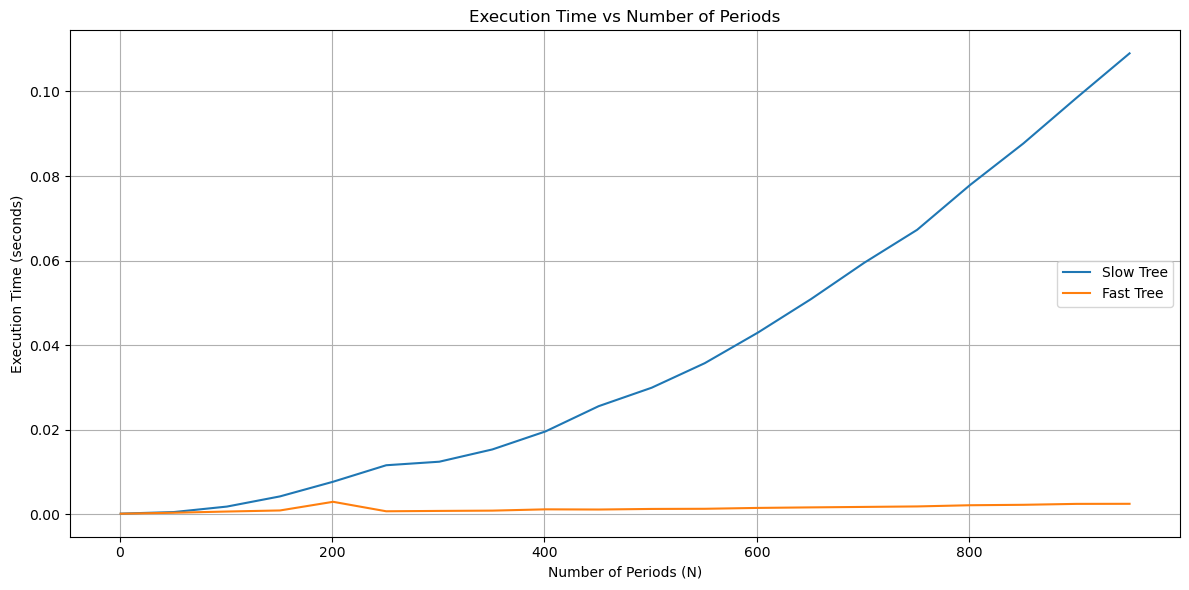

In [51]:
slow_time = []
fast_time = []
N_periods = list(range(1,1001,50))
for N in N_periods:
    _, t_slow = time_function(european_tree_slow,K,T,S0,r,l,N,u,d,opt = 'C')
    _, t_fast = time_function(european_tree_fast,K,T,S0,r,l,N,u,d,opt = 'C')
    slow_time.append(t_slow)
    fast_time.append(t_fast)

plt.figure(figsize=(12,6))
plt.plot(N_periods,slow_time, label ="Slow Tree")
plt.plot(N_periods,fast_time, label = "Fast Tree")
plt.xlabel("Number of Periods (N)")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time vs Number of Periods")
plt.legend(loc = 'center right')
plt.grid(True)
plt.tight_layout()
plt.show()
    
